In [0]:
#Uncomment line below and run if you need to clear all your resources
#!kill -9 -1

In [0]:
#Upgrade to the latest scipy to get rid of a warning message in later installs
!pip install --upgrade scipy -q

In [0]:
#Install the version of pytorch required for fastai (0.4.0 also works but you get warning messages)
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl -q && pip install torchvision -q

In [0]:
#Instal fastai
!pip install fastai -q

RESTART RUNTIME (FROM TOOL BAR) AFTER COMPLETING THE ABOVE INSTALLS:  Runtime -> Restart runtime...

In [1]:
#Just checking to see what directories are visible
!ls

data  datalab


In [0]:
#Create directory for holding all the data
!mkdir dogcat-data

In [3]:
#Just checking that the data directory was installed
!ls

data  datalab  dogcat-data


In [4]:
#Download the dataset
!wget http://files.fast.ai/data/dogscats.zip

--2018-08-13 05:40:41--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  42.1MB/s    in 20s     

2018-08-13 05:41:01 (41.0 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



In [5]:
#Make sure the dataset downloaded
!ls

data  datalab  dogcat-data  dogscats.zip


In [0]:
#Unzip dataset to data directory
!unzip -qq dogscats.zip -d dogcat-data/

In [0]:
#Configure plots to display inside the notebook
%matplotlib inline

In [0]:
#Imports
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
#path to the data
PATH = "dogcat-data/dogscats/"

#size of the images (224x224)
sz=224


In [10]:
#Just make sure cuda is available. If False is returned then go into you Runtime setting and enable GPU
torch.cuda.is_available()

True

In [11]:
#Just checking for cudnn. If False is returned then go into you Runtime setting and enable GPU
torch.backends.cudnn.enabled

True

In [12]:
#Taking a quick peak inside the data/dogscats directory
os.listdir(PATH)

['train', 'sample', 'valid', 'models', 'test1']

In [13]:
#Taking a quick peaking inside the validation folder, subfolders names are the labels (categories to classify)
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [14]:
#Selecting a few of the cat images from the validation set
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.5089.jpg',
 'cat.2300.jpg',
 'cat.12100.jpg',
 'cat.2283.jpg',
 'cat.10959.jpg']

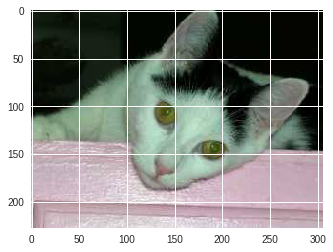

In [15]:
#Displaying one of the cat images, notice that is isn't exactly 224x224
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [16]:
img.shape

(228, 306, 3)

In [0]:
# Uncomment the below if you need to reset your precomputed activations
#shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [18]:
#Define our pretrained network architecture
arch=resnet34

#Load our date from disk, images will be nomalized
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

#Create your model from a pretrained (with ImageNet) resenet architecture. Add new fully connected layers at the end.
learn = ConvLearner.pretrained(arch, data, precompute=True)

#Train for 5 epochs with a learning rate of 0.01
learn.fit(0.01, 5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 84350428.29it/s]


100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.057399   0.027442   0.9915    
    1      0.042681   0.027678   0.991     
    2      0.039013   0.025361   0.992     
    3      0.032563   0.032564   0.99      
    4      0.042939   0.026466   0.9905    



[array([0.02647]), 0.9905]

In [19]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [20]:
log_preds[:10]

array([[ -0.00017,  -8.66398],
       [ -0.00001, -11.49533],
       [ -0.00003, -10.59208],
       [ -0.0001 ,  -9.2069 ],
       [ -0.00001, -11.12994],
       [ -0.00007,  -9.55462],
       [ -0.00744,  -4.90401],
       [ -0.     , -13.71044],
       [ -0.00003, -10.2918 ],
       [ -0.00007,  -9.50024]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [0]:
def rand_by_mask(mask): 
  return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): 
  return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plot_val_with_title(idxs, title):
  imgs = np.stack([data.val_ds[x][0] for x in idxs])
  title_probs = [probs[x] for x in idxs]
  print(title)
  return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
  f = plt.figure(figsize=figsize)
  for i in range(len(ims)):
    sp = f.add_subplot(rows, len(ims)//rows, i+1)
    sp.axis('Off')
    if titles is not None: 
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): 
  return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
  imgs = [load_img_id(data.val_ds,x) for x in idxs]
  title_probs = [probs[x] for x in idxs]
  print(title)
  return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


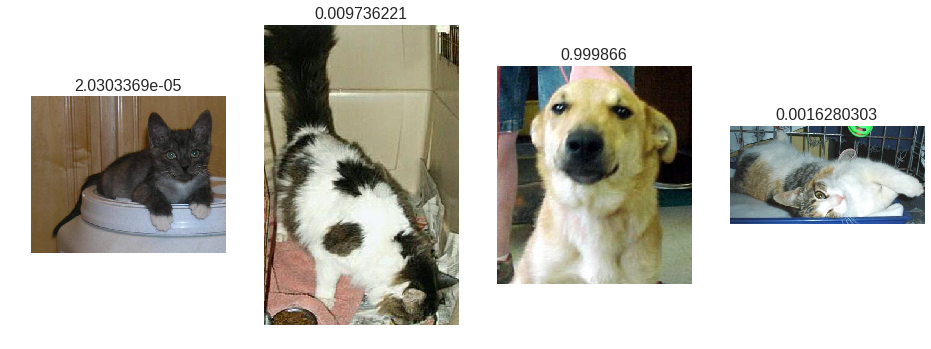

In [26]:
# A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


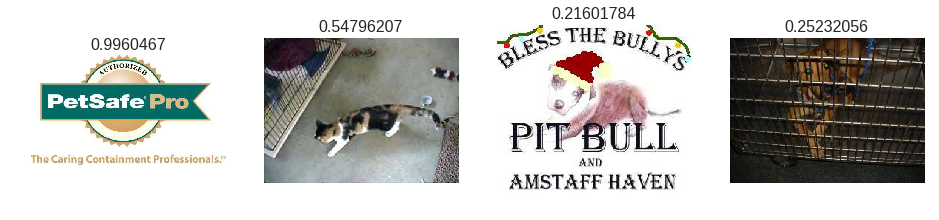

In [27]:
# A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


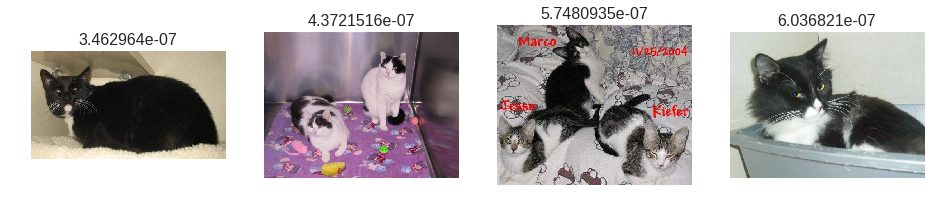

In [29]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")


Most correct dogs


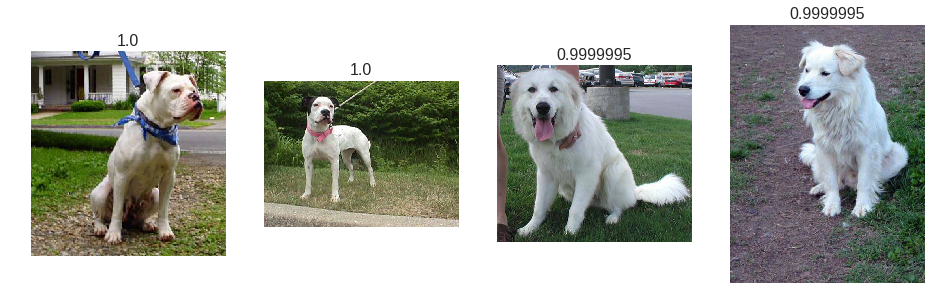

In [30]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


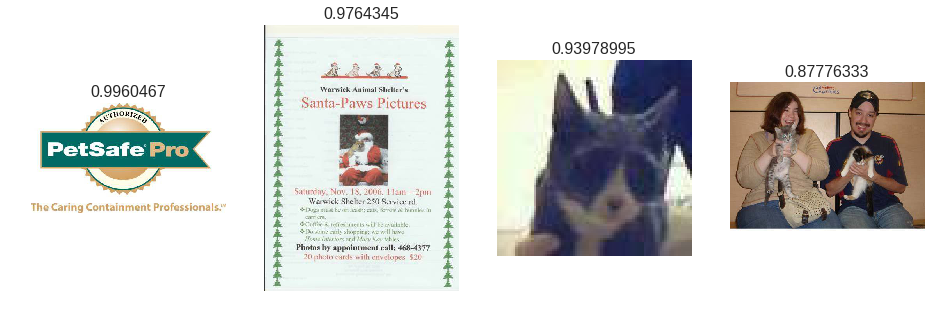

In [31]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


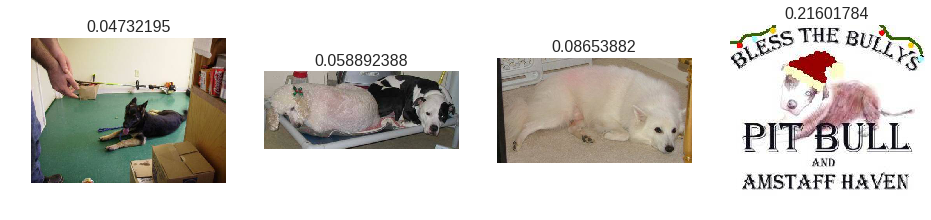

In [32]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


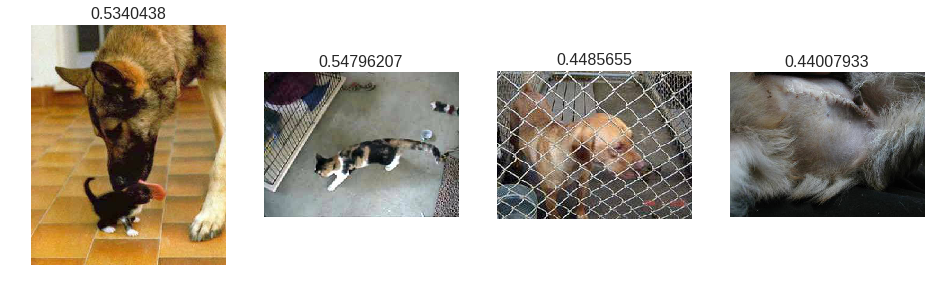

In [33]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [0]:
#Reseting the model to show off the learning rate finder
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [35]:
#Configuring the learning rate finder
lrf=learn.lr_find()

 81%|████████  | 290/360 [00:07<00:01, 38.40it/s, loss=0.418]


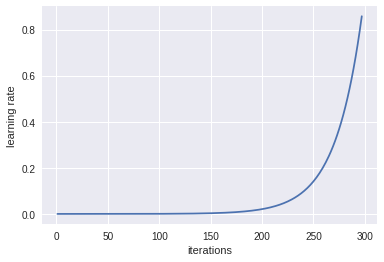

In [36]:
#Plotting the exponential growth of the learning rate
learn.sched.plot_lr()

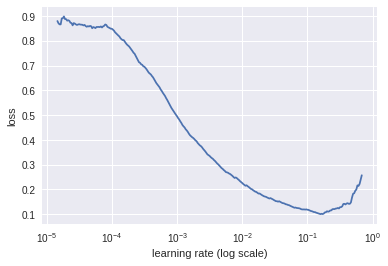

In [37]:
#Plotting loss vs. learning rate, we are interested in the learning rate value just before we hit our minimum loss
learn.sched.plot()

In [0]:
#Next we should explore data augmentation during training
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
#Method to help us visualize what data augmentation is doing
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
#Generate 6 augmented version of an image
ims = np.stack([get_augs() for i in range(6)])

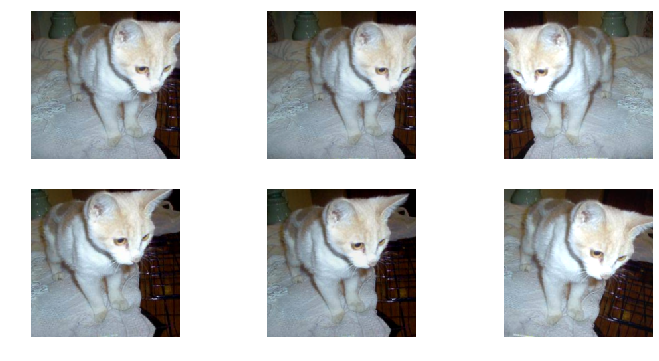

In [41]:
plots(ims, rows=2)

In [0]:
#Now create our data set with data augmentation enabled
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [43]:
#Run a single epoch, data augmentation isn't being utilized just yet
learn.fit(1e-2, 1)


epoch      trn_loss   val_loss   accuracy   
    0      0.048192   0.026965   0.991     



[array([0.02696]), 0.991]

In [0]:
#Now turn precompute off to take advantage of of data augmentation
learn.precompute=False

In [45]:
#Train for 3 more epochs, might be a little slower because were are not precomputing activations
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.04966    0.026965   0.992     
    1      0.049821   0.026237   0.9905    
    2      0.043602   0.024843   0.992     



[array([0.02484]), 0.992]

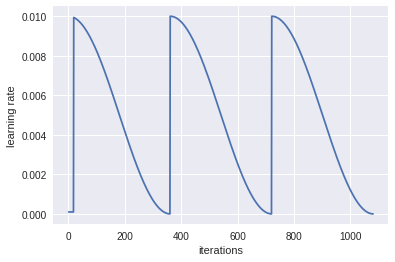

In [46]:
#The cycle_len option above defines how often the learning rate resets (SGDR)
learn.sched.plot_lr()

In [0]:
#Now we may want to train our early layers, so we unfreeze them
learn.unfreeze()

In [0]:
#The network is broken into thirds and we can control the learning rate in each section
lr=np.array([1e-4,1e-3,1e-2])

In [49]:
#Run for a few more epochs, training times will be much slower now that the early layers are being trained
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.053038   0.02471    0.993     
    1      0.039244   0.024107   0.991     
    2      0.027814   0.018312   0.993     



[array([0.01831]), 0.993]

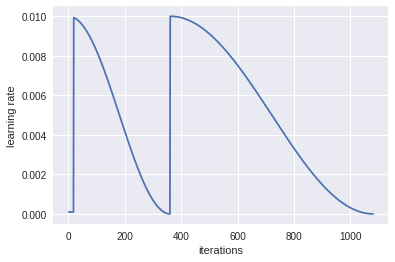

In [50]:
#Notice that the learning rate restarts are not happening at the epoch boundaries (resutl of cycle_mult parameter)
learn.sched.plot_lr()

In [51]:
#We can one more thing to improve our accuracy, Test Time Augmentation (TTA)
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [52]:
#Final accuracy
accuracy_np(probs, y)

0.9935

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
#Now we can visualize our results
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  8 992]]


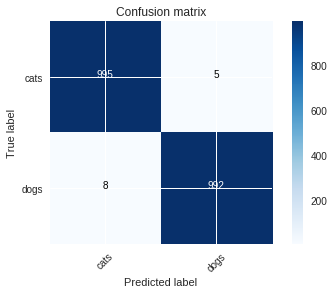

In [55]:

plot_confusion_matrix(cm, data.classes)